In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. 데이터 전처리

In [6]:
#당진, 울산 기상 관측 데이터 DNI 포함
data_dangjin = pd.read_csv('solar_power_mycode/train_dangjin.csv')
data_ulsan = pd.read_csv('solar_power_mycode/train_ulsan.csv')

In [7]:
print("Shape of data_dangjin:",data_dangjin.shape)
print("Time period: ",data_dangjin['Time'][0], "~", data_dangjin['Time'][data_dangjin.shape[0]-1])

Shape of data_dangjin: (25632, 20)
Time period:  2018-03-01 0:00 ~ 2021-01-31 23:00


In [8]:
season_feature = []
for x in range(int(data_dangjin.shape[0])):
    item = np.sin(2*np.pi*x/(24*365))
    season_feature.append(item)
season_feature = pd.DataFrame(season_feature)

In [9]:
day_and_season = pd.DataFrame(np.array(season_feature)*0.1).add(data_dangjin['cos(time)']*0.9, axis=0)

In [10]:
data_dangjin=pd.concat([data_dangjin, day_and_season], axis=1)
data_ulsan=pd.concat([data_ulsan, day_and_season], axis=1)

In [11]:
data_ulsan.rename(columns={0:'day_and_season'}, inplace = True)
data_dangjin.rename(columns={0:'day_and_season'}, inplace = True)

In [12]:
print("Shape of data_ulsan: ",data_dangjin.shape)
print("Time period: ",data_dangjin['Time'][0], "~", data_ulsan['Time'][data_dangjin.shape[0]-1])
print("Shape of data_ulsan: ",data_ulsan.shape)
print("Time period: ",data_ulsan['Time'][0], "~", data_ulsan['Time'][data_ulsan.shape[0]-1])

Shape of data_ulsan:  (25632, 21)
Time period:  2018-03-01 0:00 ~ 2021-01-31 23:00
Shape of data_ulsan:  (25632, 21)
Time period:  2018-03-01 0:00 ~ 2021-01-31 23:00


In [25]:
raw_data_dangjin = data_dangjin[['cos(time)',
                                 'GHI(W/m^2)',
                                 'DNI(W/m^2)',
                                 'Ground_Temperature',
                                 'Humidity',
                                 'Visibility',
                                 'Wind_Speed',
                                 'Wind_Direction']]
raw_power_dangjin = data_dangjin[['Power']]
raw_data_ulsan = data_ulsan[['cos(time)',
                             'GHI(W/m^2)',
                             'DNI(W/m^2)',
                             'Ground_Temperature',
                             'Humidity',
                             'Visibility',
                             'Wind_Speed',
                             'Wind_Direction']]
raw_power_ulsan = data_ulsan[['Power']]

Text(0, 0.5, 'GHI')

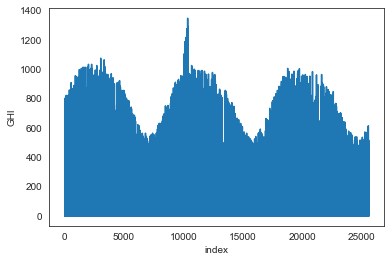

In [33]:
plt.plot(data_dangjin['GHI(W/m^2)'])
plt.xlabel('index')
plt.ylabel('GHI')

In [14]:
# 이상치 NaN 값으로 변경
'''
for i in range(len(raw_data_dangjin)):
    if raw_data_dangjin['GHI(W/m^2)'][i] < raw_data_dangjin['DNI(W/m^2)'][i]:
        raw_data_dangjin['DNI(W/m^2)'][i] = np.nan

for i in range(len(raw_data_ulsan)):
    if raw_data_ulsan['GHI(W/m^2)'][i] < raw_data_ulsan['DNI(W/m^2)'][i]:
        raw_data_ulsan['DNI(W/m^2)'][i] = np.nan
        
for i in range(len(raw_data_dangjin)):
    if raw_data_dangjin['GHI(W/m^2)'][i] < raw_data_dangjin['DNI(W/m^2)'][i]:
        raw_data_dangjin['DNI(W/m^2)'][i] = np.nan
'''
for i in range(8000,12500):
    if raw_data_dangjin['GHI(W/m^2)'][i] > 1000:
        raw_data_dangjin['GHI(W/m^2)'][i] = np.nan
'''
for i in range(len(raw_data_dangjin)):
    if raw_data_dangjin['Visibility'][i] > 5100:
        raw_data_dangjin['Visibility'][i] = np.nan
'''


C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


"\nfor i in range(len(raw_data_dangjin)):\n    if raw_data_dangjin['Visibility'][i] > 5100:\n        raw_data_dangjin['Visibility'][i] = np.nan\n"

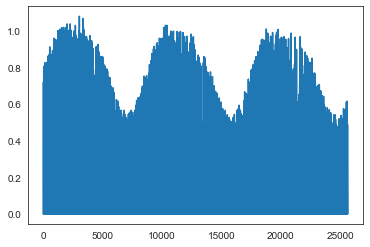

In [26]:
plt.plot(proc_data_dangjin['GHI(W/m^2)']);

In [15]:
# NaN 값들을 K-Nearest Neighbor로 값을 채워줌
from sklearn.impute import KNNImputer
from numpy import isnan

imputer = KNNImputer()
imputer.fit(raw_data_dangjin.values)
imp_data_dangjin = imputer.transform(raw_data_dangjin.values)

imputer.fit(raw_data_ulsan.values)
imp_data_ulsan = imputer.transform(raw_data_ulsan.values)

print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_data_dangjin).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_data_ulsan).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0


In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scipy as sp
import scipy.stats
scaler = MinMaxScaler()
scaler.fit(imp_data_dangjin)
scaler.fit(imp_data_ulsan)
imp_data_dangjin_scaled = scaler.transform(imp_data_dangjin)
imp_data_ulsan_scaled = scaler.transform(imp_data_ulsan)
proc_data_dangjin = pd.DataFrame(data=imp_data_dangjin_scaled, 
                                 columns=['cos(time)',
                                         'GHI(W/m^2)',
                                         'DNI(W/m^2)',
                                         'Ground_Temperature',
                                         'Humidity',
                                         'Visibility',
                                         'Wind_Speed',
                                         'Wind_Direction'])
proc_data_ulsan = pd.DataFrame(data=imp_data_ulsan_scaled, 
                                 columns=['cos(time)',
                                         'GHI(W/m^2)',
                                         'DNI(W/m^2)',
                                         'Ground_Temperature',
                                         'Humidity',
                                         'Visibility',
                                         'Wind_Speed',
                                         'Wind_Direction'])


In [264]:
#proc_data_dangjin['day_and_season'] *= 2
#proc_data_dangjin['day_and_season'] -= 1

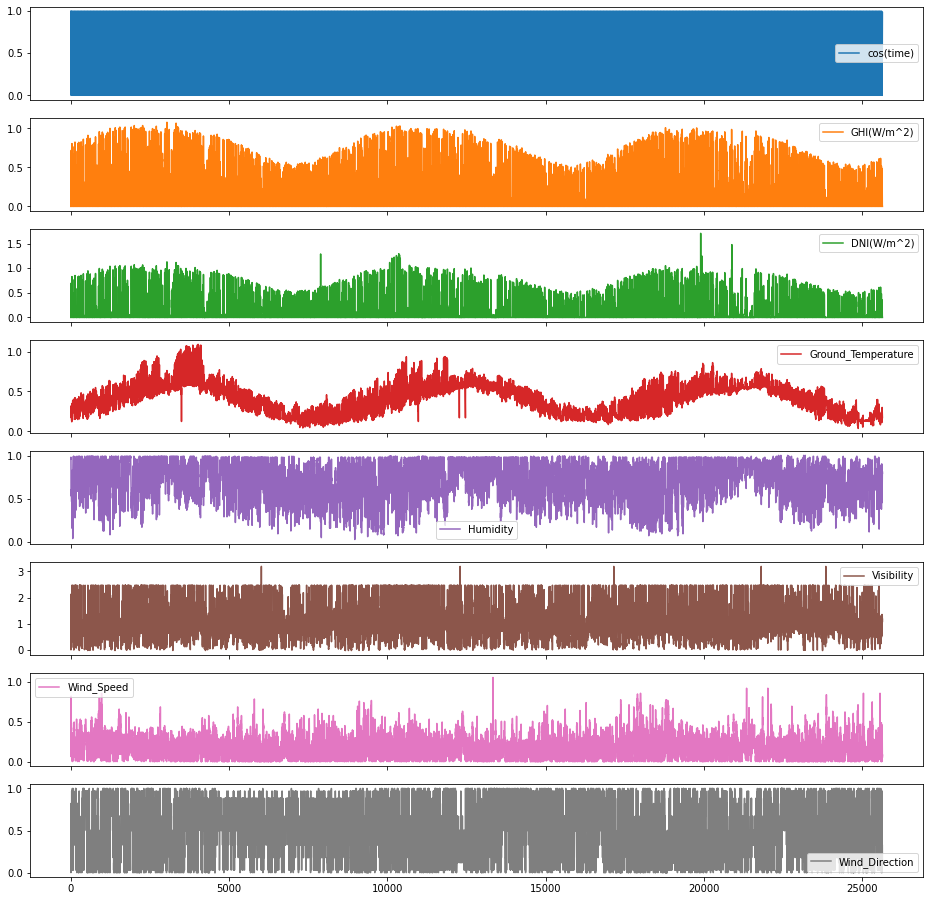

In [18]:
proc_data_dangjin.plot(subplots=True, figsize=(16, 16));

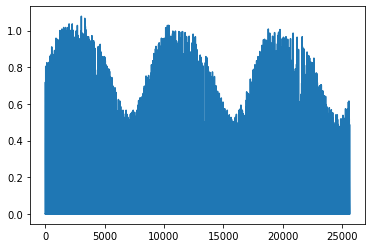

In [19]:
plt.plot(proc_data_dangjin['GHI(W/m^2)']);

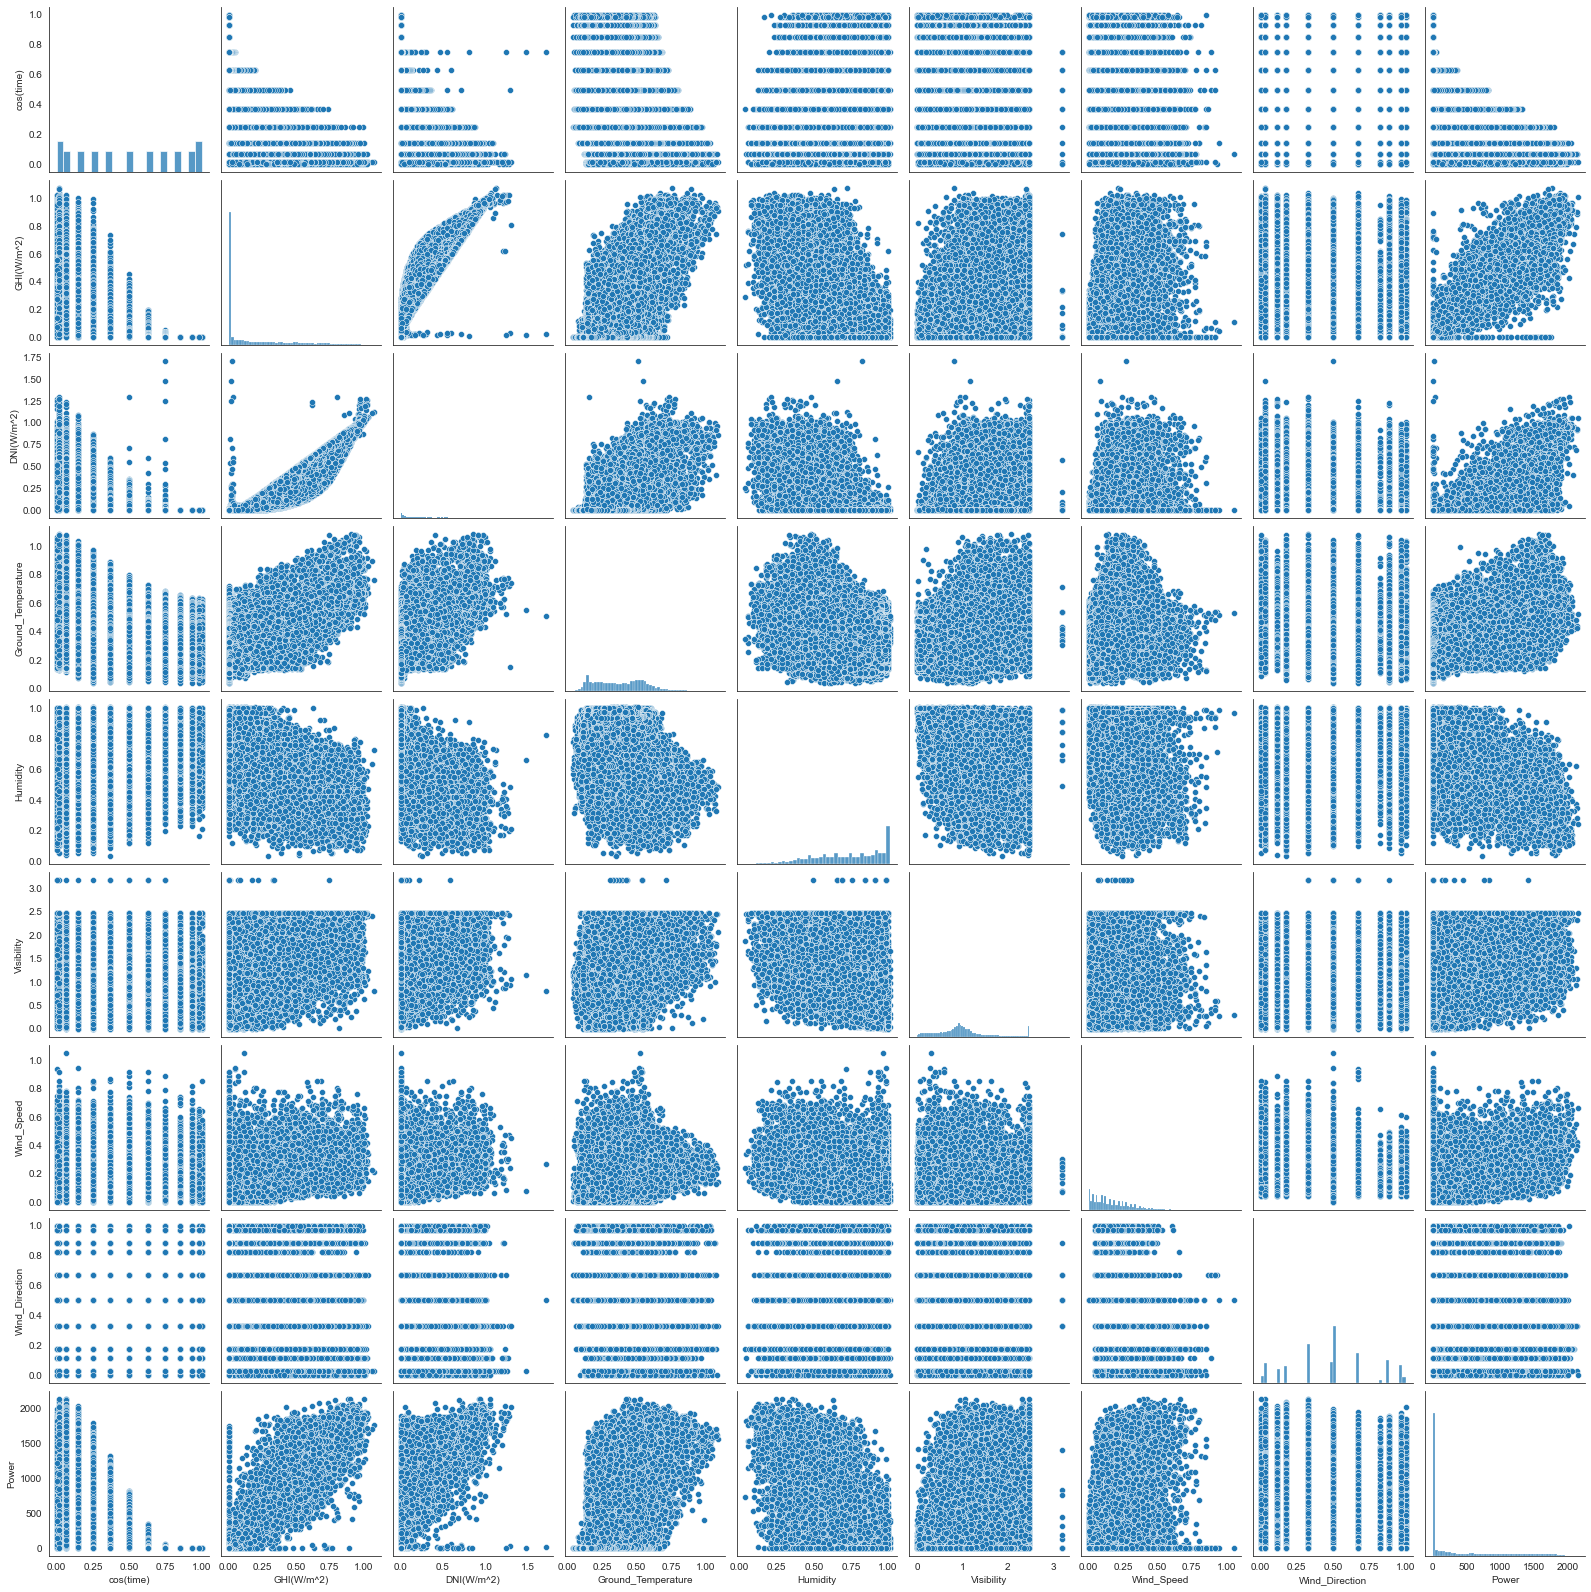

In [22]:
import seaborn as sns
sns.set_style("white")
sns.pairplot(pd.concat([proc_data_dangjin[['cos(time)',
                             'GHI(W/m^2)',
                             'DNI(W/m^2)',
                             'Ground_Temperature',
                             'Humidity',
                             'Visibility',
                             'Wind_Speed',
                             'Wind_Direction']],raw_power_dangjin],
                              axis=1));

## 2. 모델링 및 학습

In [34]:
from sklearn.model_selection import train_test_split
dangjin_temp_GHI = proc_data_dangjin[:24888]
ulsan_temp_GHI = proc_data_ulsan[:24888]
label_dangjin = raw_power_dangjin[:24888]
label_ulsan = raw_power_ulsan[:24888]
GHI_x_train_dangjin, GHI_x_test_dangjin, y_train_dangjin, y_test_dangjin = train_test_split(dangjin_temp_GHI,
                                                                                           label_dangjin,
                                                                                           test_size = 0.2,
                                                                                           shuffle = False)

GHI_x_train_ulsan, GHI_x_test_ulsan, y_train_ulsan, y_test_ulsan = train_test_split(ulsan_temp_GHI,
                                                                                   label_ulsan,
                                                                                   test_size = 0.2,
                                                                                   shuffle = False)
                                                                                                   

In [ ]:
from sklearn.model_selection import train_test_split
dangjin_temp_GHI = proc_data_dangjin[:24888]
ulsan_temp_GHI = proc_data_ulsan[:24888]
label_dangjin = raw_power_dangjin[:24888]
label_ulsan = raw_power_ulsan[:24888]
GHI_x_train_dangjin, GHI_x_test_dangjin, y_train_dangjin, y_test_dangjin = train_test_split(dangjin_temp_GHI,
                                                                                           label_dangjin,
                                                                                           test_size = 0.2,
                                                                                           shuffle = False)

GHI_x_train_ulsan, GHI_x_test_ulsan, y_train_ulsan, y_test_ulsan = train_test_split(ulsan_temp_GHI,
                                                                                   label_ulsan,
                                                                                   test_size = 0.2,
                                                                                   shuffle = False)

In [35]:
#25632, 24888
dangjin_temp_GHI.shape

(24888, 8)

In [36]:
print(GHI_x_train_dangjin.shape)
print(GHI_x_test_dangjin.shape)
print(y_train_dangjin.shape)
print(y_test_dangjin.shape)

(19910, 8)
(4978, 8)
(19910, 1)
(4978, 1)


In [37]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,20))

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    plt.ylim([0,150])
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.ylim([0,80])
    plt.legend()
    plt.show()

In [76]:
from keras import layers
def build_model_GHI():
    model = keras.Sequential([
                            layers.Dense(256, activation='relu', input_shape=[len(GHI_x_train_dangjin.keys())]),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(32, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae','mse'])
    return model

In [77]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

EPOCHS = 200
model_dangjin = build_model_GHI()
history_dangjin = model_dangjin.fit(
                    GHI_x_train_dangjin, y_train_dangjin,
                    epochs=EPOCHS, batch_size = 128, validation_split = 0.2, verbose=2,
                    callbacks=[es,mc])

Epoch 1/200
125/125 - 6s - loss: 188.0961 - mae: 188.0961 - mse: 156226.1094 - val_loss: 87.6848 - val_mae: 87.6848 - val_mse: 31870.5234
Epoch 2/200
125/125 - 1s - loss: 121.1913 - mae: 121.1913 - mse: 61876.5703 - val_loss: 73.1641 - val_mae: 73.1641 - val_mse: 25010.2070
Epoch 3/200
125/125 - 0s - loss: 119.8830 - mae: 119.8830 - mse: 60590.5391 - val_loss: 89.5076 - val_mae: 89.5076 - val_mse: 34024.7812
Epoch 4/200
125/125 - 0s - loss: 110.8138 - mae: 110.8138 - mse: 52731.6836 - val_loss: 82.4121 - val_mae: 82.4121 - val_mse: 29297.1016
Epoch 5/200
125/125 - 0s - loss: 111.3898 - mae: 111.3898 - mse: 52922.6406 - val_loss: 73.6879 - val_mae: 73.6879 - val_mse: 25001.6973
Epoch 6/200
125/125 - 0s - loss: 110.6897 - mae: 110.6897 - mse: 52488.4805 - val_loss: 80.4863 - val_mae: 80.4863 - val_mse: 28362.2695
Epoch 7/200
125/125 - 0s - loss: 109.6212 - mae: 109.6212 - mse: 51317.8477 - val_loss: 68.6890 - val_mae: 68.6890 - val_mse: 22537.7910
Epoch 8/200
125/125 - 0s - loss: 109.435

Epoch 61/200
125/125 - 0s - loss: 92.6133 - mae: 92.6133 - mse: 38725.8594 - val_loss: 65.4228 - val_mae: 65.4228 - val_mse: 21881.9844
Epoch 62/200
125/125 - 0s - loss: 94.3806 - mae: 94.3806 - mse: 39332.9102 - val_loss: 69.2732 - val_mae: 69.2732 - val_mse: 23336.3984
Epoch 63/200
125/125 - 0s - loss: 93.0238 - mae: 93.0238 - mse: 38833.0156 - val_loss: 70.3080 - val_mae: 70.3080 - val_mse: 23480.9258
Epoch 64/200
125/125 - 0s - loss: 92.6305 - mae: 92.6305 - mse: 38441.9961 - val_loss: 67.1872 - val_mae: 67.1872 - val_mse: 23095.5664
Epoch 65/200
125/125 - 0s - loss: 92.1566 - mae: 92.1566 - mse: 38579.9258 - val_loss: 78.8351 - val_mae: 78.8351 - val_mse: 27453.7344
Epoch 66/200
125/125 - 0s - loss: 92.9253 - mae: 92.9253 - mse: 38833.9219 - val_loss: 73.5727 - val_mae: 73.5727 - val_mse: 25045.9766
Epoch 67/200
125/125 - 0s - loss: 92.3612 - mae: 92.3612 - mse: 38366.4883 - val_loss: 84.7733 - val_mae: 84.7733 - val_mse: 31849.2441
Epoch 68/200
125/125 - 0s - loss: 94.4077 - mae:

In [78]:
model_DNI = build_model_GHI()
history_DNI = model_DNI.fit(GHI_x_train_dangjin, y_train_dangjin,
                    epochs=EPOCHS, batch_size = 128, validation_split = 0.2, verbose=2,
                    callbacks=[es,mc])

Epoch 1/200
125/125 - 0s - loss: 190.1288 - mae: 190.1288 - mse: 160077.8750 - val_loss: 84.3124 - val_mae: 84.3124 - val_mse: 30065.4355
Epoch 2/200
125/125 - 0s - loss: 118.6157 - mae: 118.6157 - mse: 59371.7969 - val_loss: 99.5659 - val_mae: 99.5659 - val_mse: 40992.6289
Epoch 3/200
125/125 - 0s - loss: 114.9456 - mae: 114.9456 - mse: 56699.6211 - val_loss: 73.4551 - val_mae: 73.4551 - val_mse: 25412.1074
Epoch 4/200
125/125 - 0s - loss: 112.5584 - mae: 112.5584 - mse: 53205.7461 - val_loss: 79.4483 - val_mae: 79.4483 - val_mse: 28753.9531
Epoch 5/200
125/125 - 0s - loss: 110.9450 - mae: 110.9450 - mse: 52354.0625 - val_loss: 75.9834 - val_mae: 75.9834 - val_mse: 25537.2793
Epoch 6/200
125/125 - 0s - loss: 107.2502 - mae: 107.2502 - mse: 49763.9219 - val_loss: 73.0986 - val_mae: 73.0986 - val_mse: 24410.6094
Epoch 7/200
125/125 - 0s - loss: 107.1205 - mae: 107.1205 - mse: 49599.8047 - val_loss: 79.2765 - val_mae: 79.2765 - val_mse: 28824.9434
Epoch 8/200
125/125 - 0s - loss: 110.102

Epoch 61/200
125/125 - 0s - loss: 91.8755 - mae: 91.8755 - mse: 38390.4688 - val_loss: 67.0621 - val_mae: 67.0621 - val_mse: 23275.3594
Epoch 62/200
125/125 - 0s - loss: 91.2430 - mae: 91.2430 - mse: 37735.4844 - val_loss: 67.2654 - val_mae: 67.2654 - val_mse: 22654.6621
Epoch 63/200
125/125 - 0s - loss: 91.3903 - mae: 91.3903 - mse: 37833.1172 - val_loss: 68.4241 - val_mae: 68.4241 - val_mse: 23401.5801
Epoch 64/200
125/125 - 0s - loss: 92.1370 - mae: 92.1370 - mse: 37813.5352 - val_loss: 71.2103 - val_mae: 71.2103 - val_mse: 24429.9258
Epoch 65/200
125/125 - 0s - loss: 90.4408 - mae: 90.4408 - mse: 37473.3242 - val_loss: 68.4414 - val_mae: 68.4414 - val_mse: 23316.7402
Epoch 66/200
125/125 - 0s - loss: 91.1461 - mae: 91.1461 - mse: 37509.9609 - val_loss: 73.7116 - val_mae: 73.7116 - val_mse: 24424.0957
Epoch 67/200
125/125 - 0s - loss: 90.2293 - mae: 90.2293 - mse: 37006.2812 - val_loss: 71.6228 - val_mae: 71.6228 - val_mse: 24581.4492
Epoch 68/200
125/125 - 0s - loss: 91.9347 - mae:

125/125 - 0s - loss: 87.5777 - mae: 87.5777 - mse: 34816.5781 - val_loss: 70.8142 - val_mae: 70.8142 - val_mse: 23158.1738
Epoch 122/200
125/125 - 0s - loss: 87.2253 - mae: 87.2253 - mse: 34669.8008 - val_loss: 69.3266 - val_mae: 69.3266 - val_mse: 23147.9023
Epoch 123/200
125/125 - 0s - loss: 87.2886 - mae: 87.2886 - mse: 34805.9492 - val_loss: 71.8518 - val_mae: 71.8518 - val_mse: 23730.3672
Epoch 124/200
125/125 - 0s - loss: 88.0125 - mae: 88.0125 - mse: 35075.4453 - val_loss: 67.4361 - val_mae: 67.4361 - val_mse: 22865.8652
Epoch 00124: early stopping


In [325]:
model_ulsan = build_model_GHI()
history_ulsan = model_ulsan.fit(
                    GHI_x_train_ulsan, y_train_ulsan,
                    epochs=EPOCHS, batch_size = 128, validation_split = 0.2, verbose=2,
                    callbacks=[es,mc])

Epoch 1/200
125/125 - 0s - loss: 31.7365 - mae: 31.7365 - mse: 4886.7114 - val_loss: 17.3937 - val_mae: 17.3937 - val_mse: 1347.8326
Epoch 2/200
125/125 - 0s - loss: 16.0721 - mae: 16.0721 - mse: 1107.2031 - val_loss: 16.2724 - val_mae: 16.2724 - val_mse: 1276.2644
Epoch 3/200
125/125 - 0s - loss: 15.4601 - mae: 15.4601 - mse: 1069.1758 - val_loss: 16.3546 - val_mae: 16.3546 - val_mse: 1253.0907
Epoch 4/200
125/125 - 0s - loss: 15.2580 - mae: 15.2580 - mse: 1061.0535 - val_loss: 16.3767 - val_mae: 16.3767 - val_mse: 1247.0085
Epoch 5/200
125/125 - 0s - loss: 15.0393 - mae: 15.0393 - mse: 1038.2729 - val_loss: 17.1871 - val_mae: 17.1871 - val_mse: 1314.1288
Epoch 6/200
125/125 - 0s - loss: 15.0334 - mae: 15.0334 - mse: 1044.5743 - val_loss: 15.6344 - val_mae: 15.6344 - val_mse: 1198.5457
Epoch 7/200
125/125 - 0s - loss: 14.8620 - mae: 14.8620 - mse: 1022.7568 - val_loss: 15.6162 - val_mae: 15.6162 - val_mse: 1181.9637
Epoch 8/200
125/125 - 0s - loss: 14.6302 - mae: 14.6302 - mse: 1005.5

Epoch 63/200
125/125 - 0s - loss: 14.0213 - mae: 14.0213 - mse: 936.2898 - val_loss: 14.4764 - val_mae: 14.4764 - val_mse: 1113.4611
Epoch 64/200
125/125 - 0s - loss: 13.8565 - mae: 13.8565 - mse: 925.0726 - val_loss: 14.4600 - val_mae: 14.4600 - val_mse: 1130.2904
Epoch 65/200
125/125 - 0s - loss: 13.9274 - mae: 13.9274 - mse: 928.5476 - val_loss: 15.2291 - val_mae: 15.2291 - val_mse: 1146.4244
Epoch 66/200
125/125 - 0s - loss: 13.8564 - mae: 13.8564 - mse: 922.1266 - val_loss: 14.8516 - val_mae: 14.8516 - val_mse: 1119.6392
Epoch 67/200
125/125 - 0s - loss: 13.8925 - mae: 13.8925 - mse: 920.4398 - val_loss: 14.5466 - val_mae: 14.5466 - val_mse: 1149.0486
Epoch 68/200
125/125 - 0s - loss: 14.0090 - mae: 14.0090 - mse: 941.3935 - val_loss: 14.7305 - val_mae: 14.7305 - val_mse: 1126.2157
Epoch 69/200
125/125 - 0s - loss: 13.9054 - mae: 13.9054 - mse: 927.2784 - val_loss: 14.2408 - val_mae: 14.2408 - val_mse: 1123.0483
Epoch 70/200
125/125 - 0s - loss: 13.8907 - mae: 13.8907 - mse: 923.3

Epoch 125/200
125/125 - 0s - loss: 13.4267 - mae: 13.4267 - mse: 888.0834 - val_loss: 14.2814 - val_mae: 14.2814 - val_mse: 1135.4796
Epoch 126/200
125/125 - 0s - loss: 13.4761 - mae: 13.4761 - mse: 896.1240 - val_loss: 14.6915 - val_mae: 14.6915 - val_mse: 1131.3248
Epoch 127/200
125/125 - 0s - loss: 13.4829 - mae: 13.4829 - mse: 896.2781 - val_loss: 15.4992 - val_mae: 15.4992 - val_mse: 1177.7037
Epoch 128/200
125/125 - 0s - loss: 13.4094 - mae: 13.4094 - mse: 885.2590 - val_loss: 15.1345 - val_mae: 15.1345 - val_mse: 1156.7667
Epoch 129/200
125/125 - 0s - loss: 13.6467 - mae: 13.6467 - mse: 905.6608 - val_loss: 14.7039 - val_mae: 14.7039 - val_mse: 1119.8467
Epoch 130/200
125/125 - 0s - loss: 13.3906 - mae: 13.3906 - mse: 881.9552 - val_loss: 15.7233 - val_mae: 15.7233 - val_mse: 1162.3286
Epoch 131/200
125/125 - 0s - loss: 13.5079 - mae: 13.5079 - mse: 893.3838 - val_loss: 14.4967 - val_mae: 14.4967 - val_mse: 1187.1263
Epoch 132/200
125/125 - 0s - loss: 13.5158 - mae: 13.5158 - ms

## 3. 평가 및 시각화

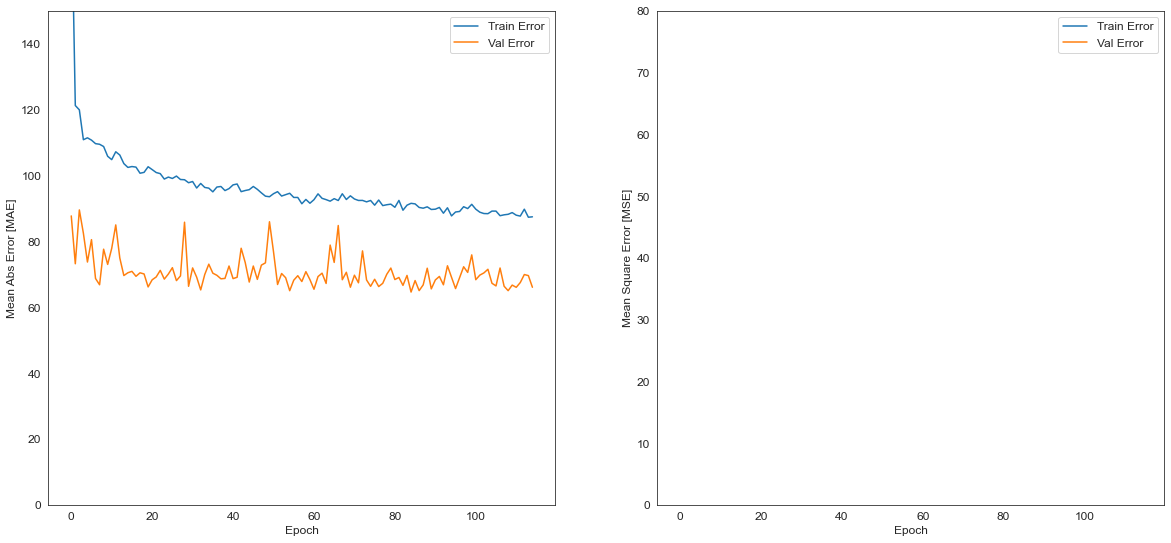

In [79]:
plot_history(history_dangjin) #Adam

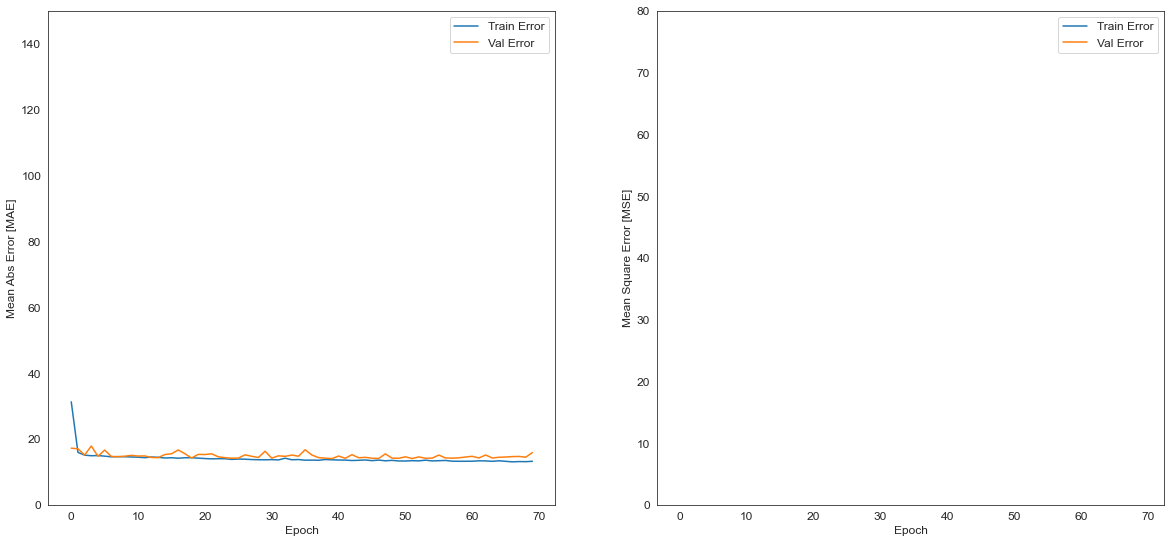

In [276]:
plot_history(history_ulsan) #Adam

In [80]:
#GHI evaluation Adam
loss1, mae1, mse1 = model_dangjin.evaluate(GHI_x_test_dangjin, y_test_dangjin, verbose=1);
print("GHI test set의 MAE: {:5.4f}".format(mae1))
print("test set MSE: {:5.4f}".format(mse1))
loss, mae, mse = model_DNI.evaluate(GHI_x_test_dangjin, y_test_dangjin, verbose=1);
print("DNI test set의 MAE: {:5.4f}".format(mae))
print("test set MSE: {:5.4f}".format(mse))

156/156 [==============================] - 0s 1ms/step - loss: 79.5888 - mae: 79.5888 - mse: 28959.5723
GHI test set의 MAE: 79.5888
test set MSE: 28959.5723
156/156 [==============================] - 0s 1ms/step - loss: 80.1228 - mae: 80.1228 - mse: 29438.8457
DNI test set의 MAE: 80.1228
test set MSE: 29438.8457


In [278]:
'''
#=========SVM 회귀==========#
from sklearn.svm import SVR

GHI_svm_reg = SVR(kernel = 'rbf',degree=3, C=1000, epsilon = 0.01, verbose = True)
GHI_svm_reg.fit(GHI_x_train_dangjin, np.ravel(y_train_dangjin, order = "c"))
'''

'\n#=========SVM 회귀==========#\nfrom sklearn.svm import SVR\n\nGHI_svm_reg = SVR(kernel = \'rbf\',degree=3, C=1000, epsilon = 0.01, verbose = True)\nGHI_svm_reg.fit(GHI_x_train_dangjin, np.ravel(y_train_dangjin, order = "c"))\n'

In [51]:
#=========XGBoost 회귀==========#
import xgboost
from xgboost import XGBRegressor
GHI_xgb_reg = XGBRegressor()
GHI_xgb_reg.fit(GHI_x_train_dangjin, y_train_dangjin)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
import lightgbm
from lightgbm import LGBMRegressor
GHI_lgbm_reg = LGBMRegressor(boosting_type='gbdt',
                            num_leaves = 256,
                            max_depth = 9,
                            learning_rate = 0.05,
                            n_estimators=100)
GHI_lgbm_reg.fit(GHI_x_train_dangjin, y_train_dangjin)

LGBMRegressor(learning_rate=0.05, max_depth=9, num_leaves=256)

In [66]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(pd.DataFrame(submission_df).iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 1000
    target_idx = pd.DataFrame(sum_answer[sum_answer>=1000*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae

In [67]:
answer_dangjin = raw_power_dangjin[24888:]
answer_ulsan = raw_power_ulsan[24888:]
dangjin_2021_01 = proc_data_dangjin[24888:]
ulsan_2021_01 = proc_data_ulsan[24888:]
MLP_submission_df = np.squeeze(model_dangjin.predict(dangjin_2021_01))
#MLP_submission_ulsan = np.squeeze(model_ulsan.predict((ulsan_2021_01)))
LGB_submission_df = np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))
#SVM_submission_df = np.squeeze(GHI_svm_reg.predict(GHI_2021_01))
XGB_submission_df = np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [68]:
print("NMAE for MLP :",Evaluate_NMAE(answer_dangjin, MLP_submission_df))
#print("NMAE for ULS :",Evaluate_NMAE(answer_ulsan, MLP_submission_ulsan))
print("NMAE for LGB :",Evaluate_NMAE(answer_dangjin, LGB_submission_df))
#print("NMAE for SVM :",Evaluate_NMAE(answer_df, SVM_submission_df))
print("NMAE for XGB :",Evaluate_NMAE(answer_dangjin, XGB_submission_df))

NMAE for MLP : 10.216185566888731
NMAE for LGB : 10.098750817430608
NMAE for XGB : 10.486179426384497


NMAE for MLP : 9.157402767670252


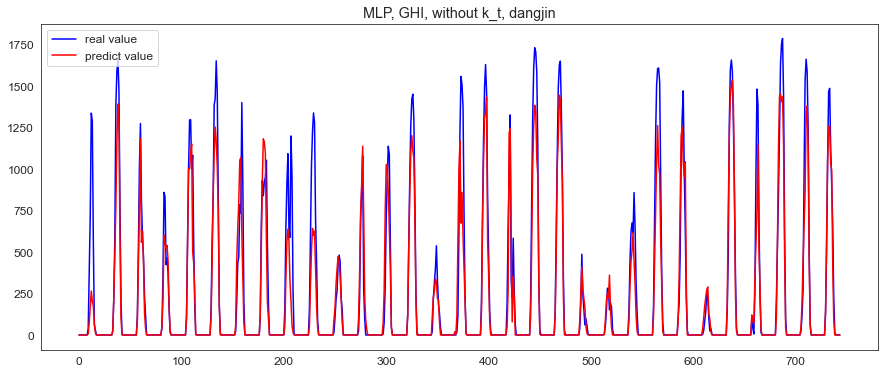

In [363]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[24888:].reset_index()
print("NMAE for MLP :",Evaluate_NMAE(answer_dangjin, MLP_submission_df))
chart.plot(reset['Power'], marker='', color='blue', label='real value')
chart.plot(np.squeeze(model_dangjin.predict(dangjin_2021_01)), marker='', color='red', label='predict value')
chart.set_title('MLP, GHI, without k_t, dangjin')
plt.legend(loc = 'best') 

In [ ]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[24888:].reset_index()
print("NMAE for LGBM :",Evaluate_NMAE(answer_dangjin, LGB_submission_df))
chart.plot(reset['Power'], marker='', color='blue', label='real value')
chart.plot(np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01)), marker='', color='red', label='predict value')
chart.set_title('LGBM, GHI, without k_t')
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[24888:].reset_index()
print("NMAE for XGBoost :",Evaluate_NMAE(answer_dangjin, XGB_submission_df))
chart.plot(reset['Power'], marker='', color='blue', label='real value')
chart.plot(np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01)), marker='', color='red', label='predict value')
chart.set_title('XGBoost, GHI, without k_t')
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(211)
sns.lineplot(data=data_dangjin, x= data_dangjin.index, y = 'Power', linewidth = 0.2)